In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import utils

from utils import total_variation_distance
from scipy.stats import multivariate_normal as mv_norm
%matplotlib inline

# Metropolis-Adjusted Langevin

In [20]:
def mala(X, dX, init_func, num_samples, delta=1.2, step=1):
    ### Note that since X is a log-density and the proposal
    ### density (q) is gaussian, we can certainly reduce the
    ### acceptance ratio to some e^{}, would improve runtime
#     prop_ratio = lambda x_hat, x: np.exp((-() + ()) / (2 * delta)) )
    result = np.array([init_func()], dtype=np.float64)
    dim = len(result[0])
    for x in range(num_samples):
        start_pos = np.copy(result[-1])
        discretized_brownian = mv_norm.rvs(cov=np.eye(dim)*delta)
        proposed = start_pos + (delta**2) * dX(start_pos) / 2 + discretized_brownian
        
#         q_bot = mv_norm.pdf(proposed, mean=start_pos + (delta**2) * dX(start_pos) / 2, cov=np.eye(dim)*(delta**2))
#         q_top = mv_norm.pdf(start_pos, mean=proposed + (delta**2) * dX(proposed) / 2, cov=np.eye(dim)*(delta**2))
#         alpha = (np.exp(X(proposed)) * q_top) / (np.exp(X(start_pos)) * q_bot)
        alpha = np.exp((X(proposed) + np.linalg.norm(start_pos + (delta**2) * dX(start_pos) / 2 - proposed) ** 2 / (2 * delta**2)) -
                       (X(start_pos) + np.linalg.norm(proposed + (delta**2) * dX(proposed) / 2 - start_pos)**2 / (2 * delta**2)) )
#         print(alpha, proposed)
        next_state = proposed if stats.bernoulli.rvs(min(1, alpha), size=1) else start_pos
        result = np.append(result, [next_state], axis=0)
    return result[::step]

# Bivariate Gaussian

In [3]:
def U(mu, sigma_inv):
    def f(x):
        return -0.5 * (x - mu).T @ sigma_inv @ (x - mu)
    return f

def dU(mu, sigma_inv):
    def f(x):
        return -(x - mu).T @ sigma_inv
    return f

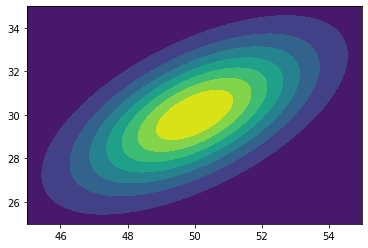

In [23]:
mu = np.array([50., 30.], np.float64)
cov = np.array([[5, 3], [3, 5]], np.float64)
ptial, d_ptial = U(mu, np.linalg.inv(cov)), dU(mu, np.linalg.inv(cov))

X, Y = np.mgrid[45:55:0.078, 25:35:0.078]
pos = np.dstack((X, Y))

gauss = stats.multivariate_normal(mu, cov).pdf(pos)
plt.contourf(X, Y, gauss)
plt.show()

[49.19940308 29.60033372] [5.13563151 5.52300896]
[50.28417343 30.25548652] [2.16237574 3.36007193]
[49.89070125 29.62349681] [4.61731139 3.11901941]
[49.94707206 29.98054986] [2.80444705 3.67933129]
[50.4429898  30.15600865] [3.62637997 3.62658904]
[50.39596164 30.35472827] [3.98711986 3.87366094]
[49.50776029 29.53046203] [4.88589408 4.85094669]
[49.87251516 30.12372367] [5.08473393 4.65700154]
[50.16504365 30.21184761] [4.11352347 4.23573071]
[49.76971781 29.58775193] [3.16284201 3.21388927]
[50.07996539 29.98624569] [4.04076855 4.25874801]
[50.07910019 30.04602949] [4.32955114 4.21195825]
[49.84843518 29.75737524] [3.91650512 4.01193988]
[49.93855302 29.95529452] [4.16281065 4.07167037]
[49.79546555 29.78759754] [3.85628607 3.96742394]
[50.14542861 30.18654954] [3.92858292 4.25536787]
[50.10975206 30.1292606 ] [4.18858265 3.87798332]
[49.94415755 29.97194738] [4.27014486 4.44521069]


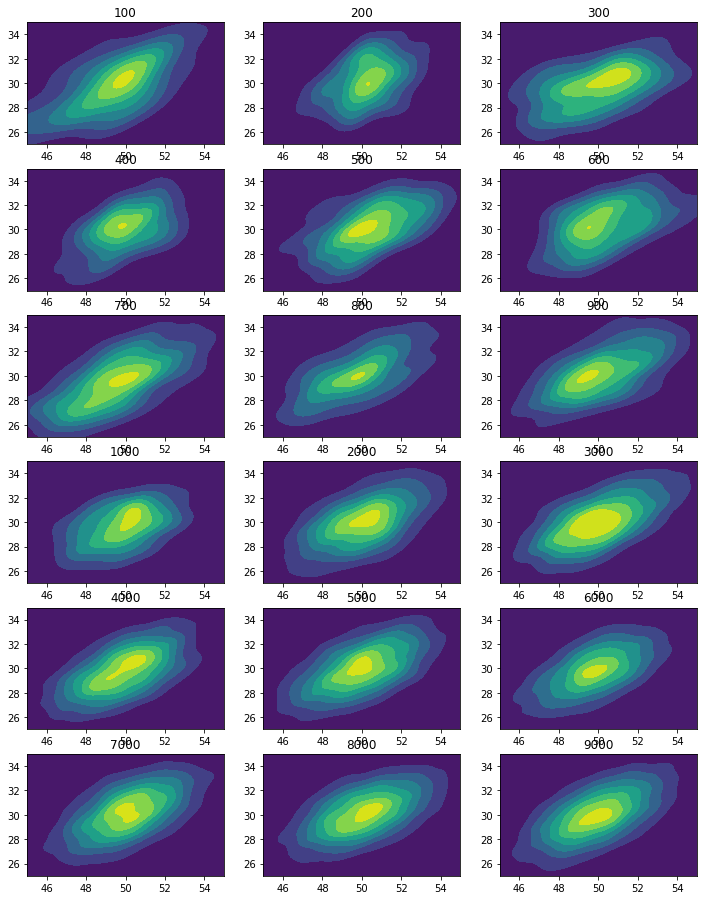

In [24]:
init_func = lambda: mu
tvd = np.array([], np.float64)
plt.figure(figsize=(12,48))
for a, i in enumerate(np.append(np.arange(100, 1000, 100), np.arange(1000, 10000, 1000))):
    samples = mala(ptial, d_ptial, init_func, i)
    print(np.mean(samples, axis=0), np.var(samples, axis=0))
    
    kde = stats.gaussian_kde(samples.T)

    estimate = np.array([kde.evaluate(x) for y in pos for x in y])
    estimate = np.reshape(estimate, (129,129))

    tvd = np.append(tvd, total_variation_distance(estimate, gauss, 0.078))

    plt.subplot(18, 3, a+1)
    plt.title(i)
    plt.contourf(X, Y, estimate)
plt.show()

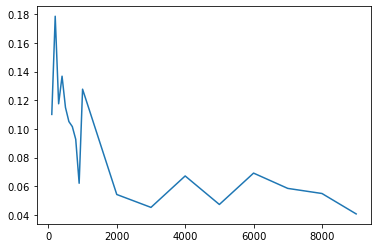

In [25]:
plt.plot(np.append(np.arange(100, 1000, 100), np.arange(1000, 10000, 1000)), tvd)
plt.show()

https://rss.onlinelibrary.wiley.com/doi/full/10.1111/j.1467-9868.2010.00765.x

https://en.wikipedia.org/wiki/Brownian_motion#Mathematics